In [1]:
import cv2 as cv
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

In [2]:
imgL = cv.imread("./sample/L_2.png", cv.IMREAD_GRAYSCALE)
imgR = cv.imread("./sample/R_2.png", cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

In [3]:
imgSift = cv.drawKeypoints(
    imgL, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imshow("SIFT Keypoints", imgSift)
cv.waitKey(0)
cv.destroyAllWindows()

In [4]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [5]:
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    imgL, kp1, imgR, kp2, matches[300:500], None, **draw_params)
cv.imshow("Keypoint matches", keypoint_matches)
cv.waitKey(0)
cv.destroyAllWindows()

In [6]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

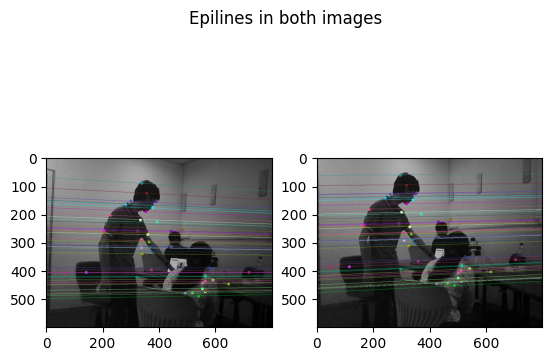

In [7]:

def drawlines(img1src, img2src, lines, pts1src, pts2src):
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)

    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color

lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)

lines1 = lines1.reshape(-1, 3)

img5, img6 = drawlines(imgL, imgR, lines1, pts1, pts2)

lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(imgR, imgL, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

In [22]:
h1, w1 = imgL.shape
h2, w2 = imgR.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

In [24]:
img1_rectified = cv.warpPerspective(imgL, H1, (w1, h1))
img2_rectified = cv.warpPerspective(imgR, H2, (w2, h2))
cv.imshow("rectified_1.png", img1_rectified)
cv.imshow("rectified_2.png", img2_rectified)
cv.waitKey(0)
cv.destroyAllWindows()

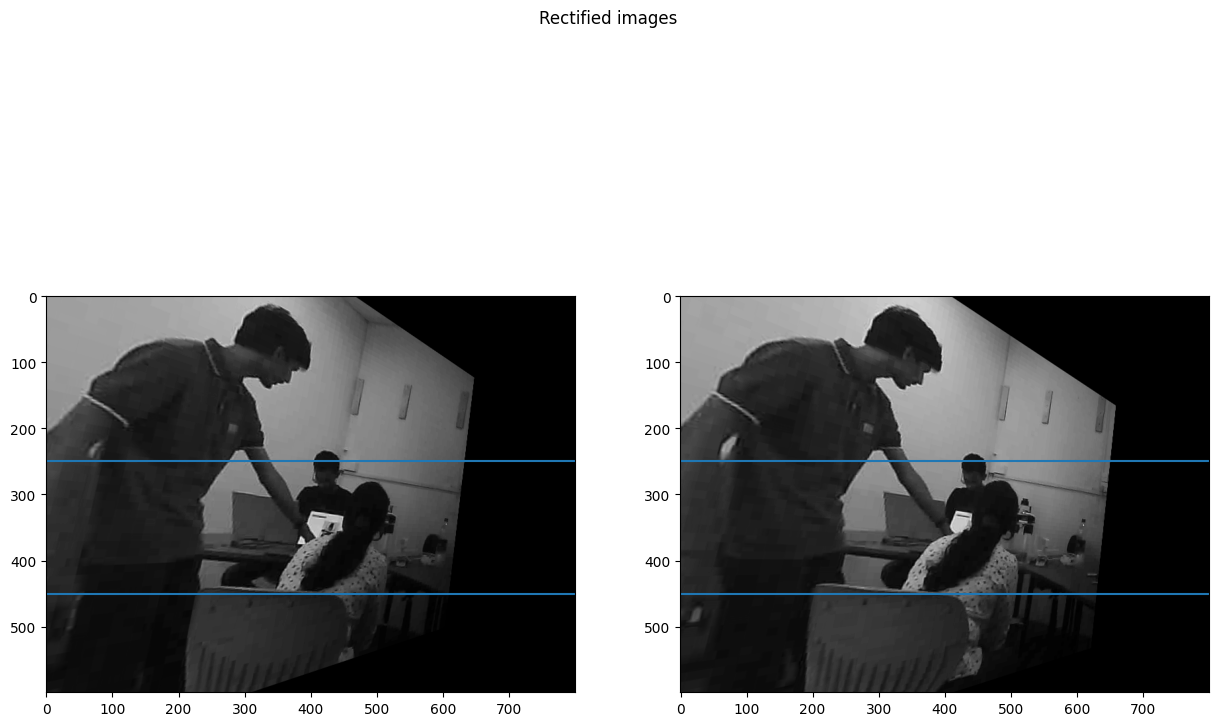

In [25]:
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.show()

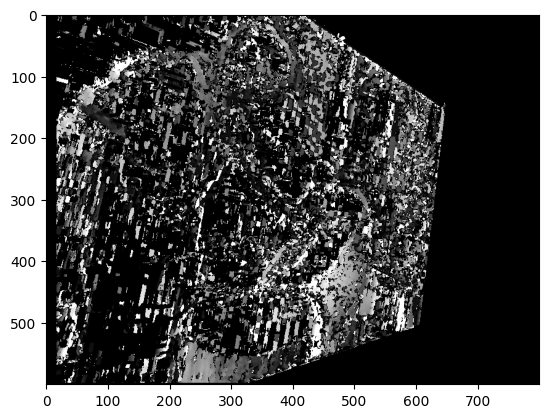

In [30]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=5)
disparity = stereo.compute(img1_rectified,img2_rectified)
plt.imshow(disparity,'gray')
plt.show()